# Imports

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.load('pred/feats_train.npy')
yb = np.load('pred/targs_train.npy')

In [4]:
xq = np.load('pred/feats_valid.npy')
yq = np.load('pred/targs_valid.npy')

In [4]:
# xb: nb-by-d
xb.shape, yb.shape

((18216, 512), (18216,))

In [6]:
#xq: nq-by-d (query vectors)
xq.shape, yq.shape

((15476, 512), (15476,))

In [5]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 539)

In [6]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [7]:
xb.max()

73.03209

In [8]:
faiss.normalize_L2(xb)

In [9]:
xb.max()

0.46980146

In [10]:
index.train(xb)

In [11]:
index.add_with_ids(xb, yb)

In [12]:
print(index.is_trained)
print(index.ntotal)

True
18216


## Train dataset

In [13]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[126 126 126 126 126]
 [239 239 239 239 239]
 [237 237 237 237 237]
 [ 50  50  50  50  50]
 [ 44  44  44  44  44]]
[[126]
 [239]
 [237]
 [ 50]
 [ 44]]
[[0.9999998  0.9880098  0.9848168  0.9839691  0.98393524]
 [1.         0.9981439  0.9980813  0.9978048  0.99780285]
 [1.         0.99562585 0.99453723 0.9942003  0.99238783]
 [1.         0.9961628  0.99614245 0.9953449  0.9953204 ]
 [0.99999994 0.96003765 0.9442349  0.9430369  0.94047797]]


In [14]:
yb.max(), I_train.max()

(276, 276)

### Train accuracy

In [15]:
I_train[:,0].shape, yb.shape

((18216,), (18216,))

In [16]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [17]:
I_train[:10,0], yb[:10]

(array([126, 239, 237,  50,  44,  45,  20,  45,  18, 187]),
 array([126, 239, 237,  50,  44,  45,  20,  45,  18, 187]))

In [18]:
I_train[-10:,0], yb[-10:]

(array([117, 271, 118, 260, 250,  37, 171, 248,   6, 254]),
 array([117, 271, 118, 260, 250,  37, 171, 248,   6, 254]))

### Train confusion matrix

In [19]:
#cm = confusion_matrix(I_train[:,0], yb)

In [22]:
#fig, ax = plt.subplots(figsize=(15,15))
#ax.matshow(cm, cmap='hot')

## Valid dataset

In [23]:
xq.max()

106.255394

In [24]:
faiss.normalize_L2(xq)

In [25]:
xq.max()

0.5085327

In [26]:
D_valid, I_valid = index.search(xq, k) # actual search

In [27]:
xq.shape, yq.shape

((15476, 512), (15476,))

In [28]:
I_valid.shape, D_valid.shape

((15476, 5), (15476, 5))

In [29]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[352 352 352 352 352]
 [744 744 744 744 744]
 [  6   6   6   6   6]
 [786 786 786 786 786]
 [ 70 647  70 715  70]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.7215791  0.7100246  0.69265807 0.68737704 0.6789496 ]
 [0.73978853 0.72794414 0.716353   0.70552933 0.70406294]
 [0.76120245 0.7598134  0.75596803 0.74069214 0.73815435]
 [0.8270298  0.8014414  0.7886761  0.6872014  0.6837535 ]
 [0.8199984  0.814927   0.8113503  0.7987522  0.7971397 ]]


In [30]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[143 976 107 976 143]
 [822 822 822 822 822]
 [824 824 824 824 824]
 [328 328 328 328 328]
 [680 680 680 680 680]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.76482654 0.7475412  0.7268312  0.72216296 0.7185513 ]
 [0.8167161  0.8093269  0.8087803  0.8050904  0.80462676]
 [0.92368823 0.9222201  0.9206244  0.91235745 0.90000504]
 [0.7588767  0.7047354  0.6882508  0.6478981  0.6011965 ]
 [0.7874667  0.735183   0.72613204 0.7232999  0.7222518 ]]


In [31]:
np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [32]:
I_valid[:,0]

array([352, 744,   6, ..., 824, 328, 680])

In [33]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [34]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

9690

In [35]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.6261307831481003

In [36]:
valid_correct = np.equal(I_valid[:,0], yq)

In [37]:
valid_correct

array([ True, False, False, ...,  True,  True, False])

In [38]:
np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [39]:
cm = confusion_matrix(I_valid[:,0], yq)

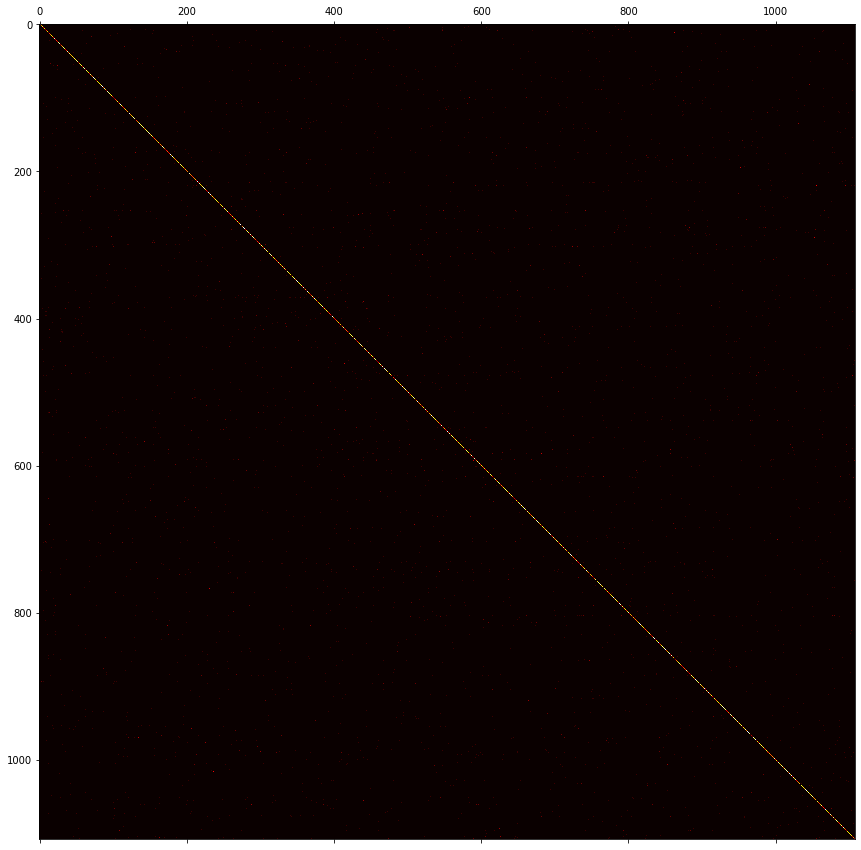

In [40]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

9690

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

5786

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.6261307831481003

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [20]:
xq_test = np.load('pred/feats_test.npy')

In [21]:
xq_test.max()

66.857185

In [22]:
faiss.normalize_L2(xq_test)

In [23]:
xq_test.max()

0.47921377

In [24]:
D_test, I_test = index.search(xq_test, k) # actual search

In [25]:
xq_test.shape, I_test.shape, D_test.shape

((9958, 512), (9958, 5), (9958, 5))

In [26]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[ 80  80  80  80  80]
 [103 103 103 103 103]
 [104 104 104 104 104]
 [  6   6   6   6   6]
 [ 37  37  37  37  37]]
[[0.9763206  0.9706608  0.96976185 0.9692405  0.9690021 ]
 [0.87265074 0.8703487  0.8360033  0.8310157  0.820255  ]
 [0.8397826  0.82655406 0.82410824 0.8110349  0.8096739 ]
 [0.9558842  0.93637675 0.9363451  0.9353919  0.9352883 ]
 [0.76456976 0.7564534  0.7509335  0.7489828  0.74261725]]


In [27]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[184 184 184 184 184]
 [142 142 142 142 142]
 [126 126 126 126 126]
 [247  -1  -1  -1  -1]
 [142 142 142 142 142]]
[[ 5.8170092e-01  5.7901907e-01  5.7243800e-01  5.7019055e-01
   5.6833732e-01]
 [ 6.8592227e-01  6.7376101e-01  6.6968668e-01  6.6900349e-01
   6.6304183e-01]
 [ 8.1836402e-01  7.6088536e-01  7.5939357e-01  7.5778556e-01
   7.5511503e-01]
 [ 5.3915149e-01 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
  -3.4028235e+38]
 [ 7.4625087e-01  7.2153264e-01  7.1910465e-01  7.1385801e-01
   7.1371865e-01]]


In [28]:
I_test[2]

array([104, 104, 104, 104, 104])

In [29]:
np.unique(I_test[2], return_counts=True)

(array([104]), array([5]))

In [30]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [31]:
np.save('pred/preds_test.npy', preds_test)
np.save('pred/dist_test.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)